## Transfer Learning VGG 16 and VGG 19 using Keras

Please download the dataset from the below url

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'D:/FINAL_Pruned_Dataset/train'
valid_path = 'D:/FINAL_Pruned_Dataset/test'



In [5]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [6]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [7]:
  # useful for getting number of output classes
folders = glob('D:/FINAL_Pruned_Dataset/train/*')

In [8]:
folders

['D:/FINAL_Pruned_Dataset/train\\MSIMUT', 'D:/FINAL_Pruned_Dataset/train\\MSS']

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [10]:
len(folders)

2

In [11]:
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [12]:

# view the structure of the model
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('D:/FINAL_Pruned_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 10000 images belonging to 2 classes.


In [16]:
test_set = test_datagen.flow_from_directory('D:/FINAL_Pruned_Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 794 images belonging to 2 classes.


In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [18]:
earlystop = EarlyStopping(patience=5)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval.
filepath="D:/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, learning_rate_reduction, earlystop, log_csv]

In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  batch_size = 16,
callbacks=callbacks_list
)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.6374
Epoch 00001: val_accuracy improved from -inf to 0.68262, saving model to D:/weights-improvement-01-0.68.hdf5
625/625 [==============================] - 276s 442ms/step - loss: 0.6918 - accuracy: 0.6374 - val_loss: 0.6077 - val_accuracy: 0.6826
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6648
Epoch 00002: val_accuracy did not improve from 0.68262
625/625 [==============================] - 149s 238ms/step - loss: 0.6593 - accuracy: 0.6648 - val_loss: 0.6740 - val_accuracy: 0.6448
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6704
Epoch 00003: val_accuracy did not improve from 0.68262
625/625 [==============================] - 148s 237ms/step - loss: 0.6526 - accuracy: 0.6704 - val_loss: 0.7105 - val_accuracy: 0.6486
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.5978 - accuracy:

In [24]:
import matplotlib.pyplot as plt

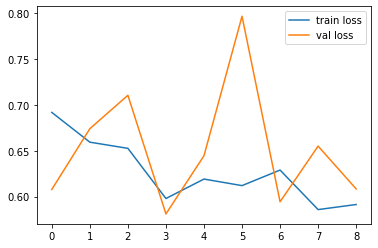

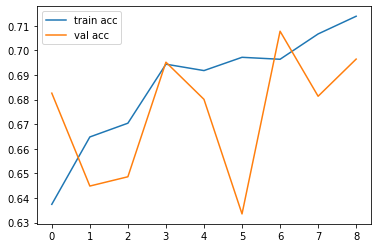

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')